two-phased method

# some variables

In [ ]:
# -------- check or show main dist
# check_working = "check"
check_working = "main_dist"

In [ ]:
%run '/content/gdrive/My Drive/Colab Notebooks/paper/01- Jupyter Notebook/90- two-phase method - class replace/config.ipynb'

Mounted at /content/gdrive
 1401.06.rar  'Colab Notebooks'


# Google Colab

In [ ]:
# Libs
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 6.6 MB/s 
     |████████████████████████████████| 965 kB 53.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
 1401.06.rar  'Colab Notebooks'


# Libs

In [ ]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read dataset

In [ ]:
df_main = pd.read_csv(
    mypaths["data"]["dataset"], 
    names=preprocessing_params["dataset"]["columns_name"], 
    dtype=preprocessing_params["dataset"]["columns_dtype"], 
    header=None
)

# ------ shrink the dataframe
if check_working == "check":
    my_indices_keep = slice(0, 100)
    df_main = df_main.iloc[my_indices_keep]
    df_main

In [ ]:
print(len(df_main))
temp_1 = df_main.groupby("bug_report_id")
temp_2 = df_main.groupby("class_id")
print(len(temp_1))
print(len(temp_2))

160524
9201
5518


# BugClassSpecify

In [ ]:
class BugClassSpecify():
    
    def __init__(self, df):
        # df: DataFrame("bug_report_id", "label|prediction_th")
        
        self.gdf = df.groupby("bug_report_id")
        
        # df_bug_pred
        columns_name = ["bug_report_id", "bug_class_2", "bug_class_3", "bug_class_4"]
        columns_dtype = ["int64", "int32", "int32", "string"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
            temp[cn] = pd.Series(dtype=cd)
        self.df_bug_pred = pd.DataFrame(temp)
        self.df_bug_pred["bug_class_4"] = pd.NA
        self.df_bug_pred["bug_report_id"] = self.gdf.groups.keys()
        self.df_bug_pred["bug_class_2"] = self.df_bug_pred["bug_class_2"].astype("Int32")
        self.df_bug_pred["bug_class_3"] = self.df_bug_pred["bug_class_3"].astype("Int32")
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self):
        self.gdf.apply(lambda g: self.sub_bug_class_(g))
    
    
    def sub_bug_class_(self, g):
        label_column = g.iloc[:, -1].to_list()
        temp = {
            "label": {
                "contain_1":  True if 1  in label_column else False,
                "contain_n1": True if -1 in label_column else False,
                "contain_0":  True if 0  in label_column else False,
            }
        }
        
        # --------- bc_2: {1, 0}
        
        bc = None
        bc = 1 if temp["label"]["contain_1"] else 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_2"] = bc
        
        
        # --------- bc_3: {1, -1, 0}
        
        bc = None
        if temp["label"]["contain_1"]:
            bc = 1
        elif temp["label"]["contain_n1"]:
            bc = -1
        else:
            bc = 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_3"] = bc
        
        
        # --------- bc_4: {+-, +, -, 0}
        
        bc = None
        if (temp["label"]["contain_1"] and temp["label"]["contain_n1"]):
            bc = "+-"
        elif temp["label"]["contain_1"]:
            bc = "+"
        elif temp["label"]["contain_n1"]:
            bc = "-"
        else:
            bc = "0"
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_4"] = bc
    
    
    def free_memory(self):
        self.gdf = None

## obj

In [ ]:
df_main_bug_preds_obj = BugClassSpecify(df_main.copy())
df_main_bug_preds_obj.bug_class()
df_main_bug_preds_obj.free_memory()
df_main_bug_preds = df_main_bug_preds_obj.df_bug_pred
df_main_bug_preds.head(20)

,bug_report_id,bug_class_2,bug_class_3,bug_class_4
0,41737,1,1,+-
1,41748,1,1,+-
2,41751,1,1,+
3,41754,1,1,+-
4,41757,0,0,0
5,41760,1,1,+-
6,41763,1,1,+-
7,41771,0,0,0
8,41774,1,1,+-
9,41778,1,1,+


# ClassDistribution

In [ ]:
class ClassDistribution:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2", "bug_class_3", "bug_class_4"]
        self.bug_class_num = {}
        self.bug_class_per = {}
        self.bug_class_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            self.bug_class_ratio[bug_class] = {}
            if i == 0: # bug_label_2
                self.bug_class_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_class_per[bug_class] =   {"0": 0, "1":  0}
            elif i == 1: # bug_label_3
                self.bug_class_num[bug_class] =   {"0": 0, "1":  0, "-1": 0}
                self.bug_class_per[bug_class] =   {"0": 0, "1":  0, "-1": 0}
            else: # bug_label_4
                self.bug_class_num[bug_class] =   {"0": 0, "+-": 0, "+":  0, "-": 0}
                self.bug_class_per[bug_class] =   {"0": 0, "+-": 0, "+":  0, "-": 0}
        
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        for mbc in self.my_bug_classes:
            self.df_bug_pred.groupby(mbc).apply(lambda g: self.sub_bln_(g, mbc))

    
    
    def sub_bln_(self, g, gby):
        self.bug_class_num[gby][str(g.name)] = len(g)
        self.bug_class_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_class_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_class_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(len(self.df_bug_pred))
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(len(self.df_bug_pred))
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[i][0]
            ax2 = axes[i][1]
            for j, cl in enumerate(self.bug_class_per[key]):
                ax1.bar(my_x[j], self.bug_class_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_class_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            

            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            

            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

## obj

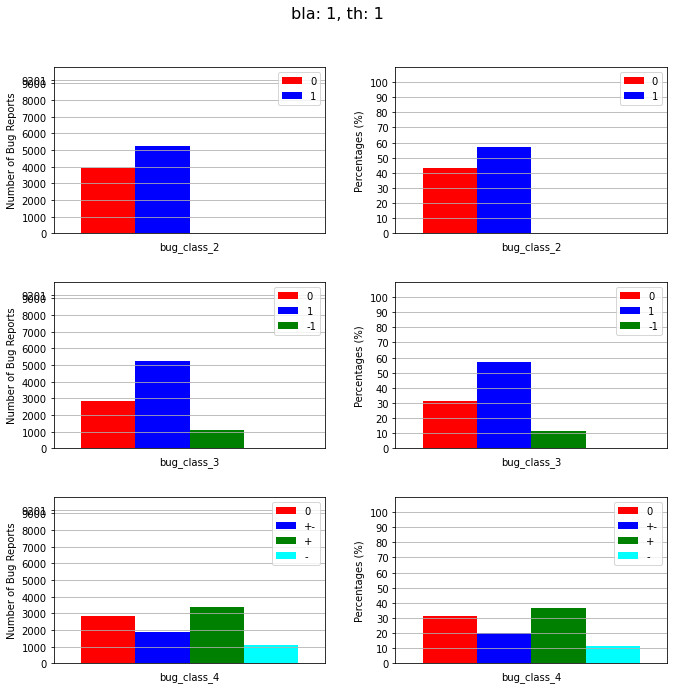

In [ ]:
df_main_bug_plot = ClassDistribution(df_main_bug_preds)
df_main_bug_plot.calc_bug_label_num_per()
df_main_bug_plot.calc_bug_label_ratios()
df_main_bug_plot.plot_percent_num(1, 1)
df_main_bug_plot.free_memory()

In [ ]:
df_main_bug_plot.bug_class_num

{'bug_class_2': {'0': 3951, '1': 5250},
 'bug_class_3': {'-1': 1085, '0': 2866, '1': 5250},
 'bug_class_4': {'+': 3376, '+-': 1874, '-': 1085, '0': 2866}}

In [ ]:
df_main_bug_plot.bug_class_per

{'bug_class_2': {'0': 42.94098467557874, '1': 57.05901532442126},
 'bug_class_3': {'-1': 11.792196500380394,
  '0': 31.148788175198348,
  '1': 57.05901532442126},
 'bug_class_4': {'+': 36.691663949570696,
  '+-': 20.36735137485056,
  '-': 11.792196500380394,
  '0': 31.148788175198348}}

In [ ]:
df_main_bug_plot.bug_class_ratio

{'bug_class_2': {'1/0': 1.3287775246772968},
 'bug_class_3': {'0/-1': 2.64147465437788,
  '1/-1': 4.838709677419355,
  '1/0': 1.83182135380321},
 'bug_class_4': {'+-/-': 1.7271889400921658,
  '+/+-': 1.8014941302027747,
  '+/-': 3.111520737327189,
  '+/0': 1.1779483600837404,
  '0/+-': 1.5293489861259337,
  '0/-': 2.64147465437788}}

# NumTimeDataset

In [ ]:
class NumTimeDataset():
    
    def __init__(self, df_main):
        self.max_bug_timestamp = 0
        self.max_bug_timestamp_bid = None
        self.num_timestamp = 40
        self.bug_timestamp_num = {}
        self.bug_timestamp_perc = {}
        
        for i in range(1, self.num_timestamp + 1):
            tempstr = "bug_timestamp_" + str(i)
            self.bug_timestamp_num[tempstr] = 0
            self.bug_timestamp_perc[tempstr] = 0
        
        temp1 = "bug_timestamp_<=" + str(self.num_timestamp)
        temp2 = "bug_timestamp_>" + str(self.num_timestamp)
        
        
        self.bug_timestamp_num[temp1] = 0
        self.bug_timestamp_num[temp2] = 0
        
        self.bug_timestamp_perc[temp1] = 0
        self.bug_timestamp_perc[temp2] = 0
    
    
    # brids: bug report ids
    # cids: class ids
    def select_brids_replace_cids(self):
        tempdf = df_main.groupby("bug_report_id")
        tempdf.apply(lambda g: self.replacement_false_(g))
        for k, percentage in self.bug_timestamp_perc.items():
            self.bug_timestamp_perc[k] = round((self.bug_timestamp_num[k] / len(tempdf)) * 100, 2)
    
    
    def replacement_false_(self, g):
        len_time_stamps = len(g)
        
        if len_time_stamps > self.num_timestamp:
            temp3 = "bug_timestamp_>" + str(self.num_timestamp)
            self.bug_timestamp_num[temp3] += 1
        
        else:
            temp4 = "bug_timestamp_<=" + str(self.num_timestamp)
            self.bug_timestamp_num[temp4] += 1
            
            for j in range(1, self.num_timestamp + 1):
                if len_time_stamps == j:
                    temp5 = "bug_timestamp_" + str(j)
                    self.bug_timestamp_num[temp5] += 1
                    break
        
        if len_time_stamps > self.max_bug_timestamp:
            self.max_bug_timestamp = len_time_stamps
            self.max_bug_timestamp_bid = g.name

## obj

In [ ]:
md = NumTimeDataset(df_main.copy())

md.select_brids_replace_cids()

In [ ]:
# print(str(md.bug_timestamp_num))
for k, v in md.bug_timestamp_num.items():
    print(k, v)

bug_timestamp_1 3259
bug_timestamp_2 1754
bug_timestamp_3 897
bug_timestamp_4 562
bug_timestamp_5 396
bug_timestamp_6 332
bug_timestamp_7 218
bug_timestamp_8 195
bug_timestamp_9 170
bug_timestamp_10 147
bug_timestamp_11 110
bug_timestamp_12 84
bug_timestamp_13 75
bug_timestamp_14 64
bug_timestamp_15 61
bug_timestamp_16 46
bug_timestamp_17 48
bug_timestamp_18 59
bug_timestamp_19 35
bug_timestamp_20 42
bug_timestamp_21 31
bug_timestamp_22 29
bug_timestamp_23 18
bug_timestamp_24 24
bug_timestamp_25 29
bug_timestamp_26 19
bug_timestamp_27 19
bug_timestamp_28 17
bug_timestamp_29 12
bug_timestamp_30 12
bug_timestamp_31 8
bug_timestamp_32 9
bug_timestamp_33 14
bug_timestamp_34 9
bug_timestamp_35 11
bug_timestamp_36 17
bug_timestamp_37 6
bug_timestamp_38 6
bug_timestamp_39 7
bug_timestamp_40 9
bug_timestamp_<=40 8860
bug_timestamp_>40 341


In [ ]:
md.bug_timestamp_perc

{'bug_timestamp_1': 35.42,
 'bug_timestamp_10': 1.6,
 'bug_timestamp_11': 1.2,
 'bug_timestamp_12': 0.91,
 'bug_timestamp_13': 0.82,
 'bug_timestamp_14': 0.7,
 'bug_timestamp_15': 0.66,
 'bug_timestamp_16': 0.5,
 'bug_timestamp_17': 0.52,
 'bug_timestamp_18': 0.64,
 'bug_timestamp_19': 0.38,
 'bug_timestamp_2': 19.06,
 'bug_timestamp_20': 0.46,
 'bug_timestamp_21': 0.34,
 'bug_timestamp_22': 0.32,
 'bug_timestamp_23': 0.2,
 'bug_timestamp_24': 0.26,
 'bug_timestamp_25': 0.32,
 'bug_timestamp_26': 0.21,
 'bug_timestamp_27': 0.21,
 'bug_timestamp_28': 0.18,
 'bug_timestamp_29': 0.13,
 'bug_timestamp_3': 9.75,
 'bug_timestamp_30': 0.13,
 'bug_timestamp_31': 0.09,
 'bug_timestamp_32': 0.1,
 'bug_timestamp_33': 0.15,
 'bug_timestamp_34': 0.1,
 'bug_timestamp_35': 0.12,
 'bug_timestamp_36': 0.18,
 'bug_timestamp_37': 0.07,
 'bug_timestamp_38': 0.07,
 'bug_timestamp_39': 0.08,
 'bug_timestamp_4': 6.11,
 'bug_timestamp_40': 0.1,
 'bug_timestamp_5': 4.3,
 'bug_timestamp_6': 3.61,
 'bug_timestam

In [ ]:
print("num cid: ", md.max_bug_timestamp)
print("bug id:  ", md.max_bug_timestamp_bid)

num cid:  2836
bug id:   48564


# NumLabel1Dataset

In [ ]:
class NumLabel1Dataset():
    
    def __init__(self, df_main):
        self.num_label1 = 100
        self.num_ts = 5
        
        self.max_bug_label1 = 0
        self.max_bug_num_ts = 0
        self.max_bug_label1_bid = None
        
        self.bug_label1_num = {}
        self.bug_label1_perc = {}
        self.bug_label1_num_class = {}
        
        
        tempra = ["<=" + str(self.num_label1), ">" + str(self.num_label1)]
        tempra.extend(list(range(0, self.num_label1 + 1)))
        #tempra.extend(["<=", ">"])
        print(tempra)
        
        tempts = list(range(1, self.num_ts + 1))
        tempts.extend(["<="  + str(self.num_ts), ">" + str(self.num_ts)])
        print(tempts)
        
        
        for i in tempra:
            tempstr = "bug_label1_" + str(i)
            self.bug_label1_num[tempstr] = 0
            self.bug_label1_perc[tempstr] = 0
            
            self.bug_label1_num_class[tempstr] = {}
            for j in tempts:
                tempnumts = "num_ts_" + str(j)
                self.bug_label1_num_class[tempstr][tempnumts] = 0
        
    
    
    # brids: bug report ids
    # cids: class ids
    def select_brids_replace_cids(self):
        tempdf = df_main.groupby("bug_report_id")
        tempdf.apply(lambda g: self.replacement_false_(g))
        for k, percentage in self.bug_label1_perc.items():
            self.bug_label1_perc[k] = round((self.bug_label1_num[k] / len(tempdf)) * 100, 2)
    
    
    def replacement_false_(self, g):
        labels = g["label"].to_list()
        num1_label = labels.count(1)
        tempKey = None
        tempKey_small = None
        
        tempKey2 = None
        
        if num1_label > self.num_label1:
            tempKey = "bug_label1_>" + str(self.num_label1)
        else:
            tempKey_small = "bug_label1_<=" + str(self.num_label1)
            self.bug_label1_num[tempKey_small] += 1
            
            tempKey = "bug_label1_" + str(num1_label)
        
        self.bug_label1_num[tempKey] += 1
        
        # ------ num_ts
        if len(labels) > self.num_ts:
            tempKey2 = "num_ts_>" + str(self.num_ts)
        else:
            tempKey2_small = "num_ts_<=" + str(self.num_ts)
            self.bug_label1_num_class[tempKey][tempKey2_small] += 1
            
            tempKey2 = "num_ts_" + str(len(labels))
        
        self.bug_label1_num_class[tempKey][tempKey2] += 1
        if tempKey_small:
            self.bug_label1_num_class[tempKey_small][tempKey2] += 1
        
        if num1_label > self.max_bug_label1:
            self.max_bug_label1 = num1_label
            self.max_bug_num_ts = len(labels)
            self.max_bug_label1_bid = g.name

## obj

In [ ]:
a = [1, 1, -1, 0, 0, 0]
a.count(-1)

1

In [ ]:
md2 = NumLabel1Dataset(df_main.copy())

# md2.bug_label1_num_class
# md2.bug_label1_num
md2.select_brids_replace_cids()

['<=100', '>100', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[1, 2, 3, 4, 5, '<=5', '>5']


In [ ]:
# print(str(md.bug_timestamp_num))
for k, v in md2.bug_label1_num.items():
    print(k, v)

bug_label1_<=100 9147
bug_label1_>100 54
bug_label1_0 3951
bug_label1_1 2623
bug_label1_2 1127
bug_label1_3 479
bug_label1_4 291
bug_label1_5 176
bug_label1_6 121
bug_label1_7 79
bug_label1_8 43
bug_label1_9 38
bug_label1_10 26
bug_label1_11 22
bug_label1_12 16
bug_label1_13 13
bug_label1_14 8
bug_label1_15 4
bug_label1_16 4
bug_label1_17 7
bug_label1_18 6
bug_label1_19 6
bug_label1_20 4
bug_label1_21 4
bug_label1_22 5
bug_label1_23 2
bug_label1_24 3
bug_label1_25 1
bug_label1_26 2
bug_label1_27 3
bug_label1_28 2
bug_label1_29 4
bug_label1_30 1
bug_label1_31 2
bug_label1_32 3
bug_label1_33 0
bug_label1_34 3
bug_label1_35 1
bug_label1_36 2
bug_label1_37 3
bug_label1_38 2
bug_label1_39 2
bug_label1_40 3
bug_label1_41 0
bug_label1_42 2
bug_label1_43 0
bug_label1_44 1
bug_label1_45 1
bug_label1_46 2
bug_label1_47 2
bug_label1_48 0
bug_label1_49 1
bug_label1_50 0
bug_label1_51 1
bug_label1_52 1
bug_label1_53 1
bug_label1_54 0
bug_label1_55 1
bug_label1_56 1
bug_label1_57 2
bug_label1_58 1
b

In [ ]:
md2.bug_label1_perc

{'bug_label1_0': 42.94,
 'bug_label1_1': 28.51,
 'bug_label1_10': 0.28,
 'bug_label1_100': 0.01,
 'bug_label1_11': 0.24,
 'bug_label1_12': 0.17,
 'bug_label1_13': 0.14,
 'bug_label1_14': 0.09,
 'bug_label1_15': 0.04,
 'bug_label1_16': 0.04,
 'bug_label1_17': 0.08,
 'bug_label1_18': 0.07,
 'bug_label1_19': 0.07,
 'bug_label1_2': 12.25,
 'bug_label1_20': 0.04,
 'bug_label1_21': 0.04,
 'bug_label1_22': 0.05,
 'bug_label1_23': 0.02,
 'bug_label1_24': 0.03,
 'bug_label1_25': 0.01,
 'bug_label1_26': 0.02,
 'bug_label1_27': 0.03,
 'bug_label1_28': 0.02,
 'bug_label1_29': 0.04,
 'bug_label1_3': 5.21,
 'bug_label1_30': 0.01,
 'bug_label1_31': 0.02,
 'bug_label1_32': 0.03,
 'bug_label1_33': 0.0,
 'bug_label1_34': 0.03,
 'bug_label1_35': 0.01,
 'bug_label1_36': 0.02,
 'bug_label1_37': 0.03,
 'bug_label1_38': 0.02,
 'bug_label1_39': 0.02,
 'bug_label1_4': 3.16,
 'bug_label1_40': 0.03,
 'bug_label1_41': 0.0,
 'bug_label1_42': 0.02,
 'bug_label1_43': 0.0,
 'bug_label1_44': 0.01,
 'bug_label1_45': 0.

In [ ]:
print("num cid: ", md2.max_bug_label1)
print("num ts:  ", md2.max_bug_num_ts)
print("bug id:  ", md2.max_bug_label1_bid)

num cid:  564
num ts:   2836
bug id:   48564


In [ ]:
md2.bug_label1_num_class

{'bug_label1_0': {'num_ts_1': 2255,
  'num_ts_2': 715,
  'num_ts_3': 288,
  'num_ts_4': 144,
  'num_ts_5': 104,
  'num_ts_<=5': 3506,
  'num_ts_>5': 445},
 'bug_label1_1': {'num_ts_1': 1004,
  'num_ts_2': 706,
  'num_ts_3': 321,
  'num_ts_4': 172,
  'num_ts_5': 99,
  'num_ts_<=5': 2302,
  'num_ts_>5': 321},
 'bug_label1_10': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num_ts_>5': 26},
 'bug_label1_100': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num_ts_>5': 1},
 'bug_label1_11': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num_ts_>5': 22},
 'bug_label1_12': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num_ts_>5': 16},
 'bug_label1_13': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num

# BugClassSpecify_per_label1

In [ ]:
class BugClassSpecify_per_label1():
    
    def __init__(self, df, l1_th):
        # df: DataFrame("bug_report_id", "label|prediction_th")
        
        self.gdf = df.groupby("bug_report_id")
        self.l1_th = l1_th
        
        # df_bug_pred
        columns_name = ["bug_report_id", "bug_class_2"]
        columns_dtype = ["int64", "int32"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
                temp[cn] = pd.Series(dtype=cd)
        self.df_bug_pred = pd.DataFrame(temp)
        self.df_bug_pred["bug_report_id"] = self.gdf.groups.keys()
        self.df_bug_pred["bug_class_2"] = self.df_bug_pred["bug_class_2"].astype("Int32")
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self):
        self.gdf.apply(lambda g: self.sub_bug_class_(g))
    
    
    def sub_bug_class_(self, g):
        # --------- bc_2: {1, 0}
        bc = None
        label_column = g.iloc[:, -1].to_list()
        label_column_num_ones = label_column.count(1)
        temp3 = label_column_num_ones / len(label_column)
        bc = 1 if temp3 >= self.l1_th else 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_2"] = bc
    
    
    def free_memory(self):
        self.gdf = None

In [ ]:
df_main_bug_preds_obj2 = BugClassSpecify_per_label1(df_main.copy(), 0.5)
df_main_bug_preds_obj2.bug_class()
df_main_bug_preds_obj2.free_memory()
df_main_bug_preds2 = df_main_bug_preds_obj2.df_bug_pred
df_main_bug_preds2.head(20)

,bug_report_id,bug_class_2
0,41737,0
1,41748,0
2,41751,1
3,41754,0
4,41757,0
5,41760,0
6,41763,0
7,41771,0
8,41774,0
9,41778,1


# ClassDistribution2

In [ ]:
class ClassDistribution2:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2"]
        self.bug_class_num = {}
        self.bug_class_per = {}
        self.bug_class_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            self.bug_class_ratio[bug_class] = {}
            if i == 0: # bug_label_2
                self.bug_class_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_class_per[bug_class] =   {"0": 0, "1":  0}
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        for mbc in self.my_bug_classes:
            self.df_bug_pred.groupby(mbc).apply(lambda g: self.sub_bln_(g, mbc))
    
    
    def sub_bln_(self, g, gby):
        self.bug_class_num[gby][str(g.name)] = len(g)
        self.bug_class_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_class_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_class_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(len(self.df_bug_pred))
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(len(self.df_bug_pred))
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[0]
            ax2 = axes[1]
            for j, cl in enumerate(self.bug_class_per[key]):
                ax1.bar(my_x[j], self.bug_class_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_class_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            
            
            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

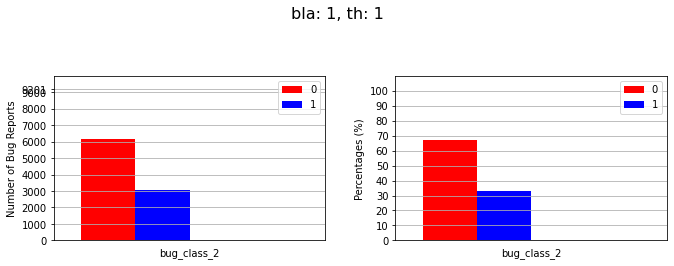

In [ ]:
df_main_bug_plot2 = ClassDistribution2(df_main_bug_preds2)
df_main_bug_plot2.calc_bug_label_num_per()
df_main_bug_plot2.calc_bug_label_ratios()
df_main_bug_plot2.plot_percent_num(1, 1)
df_main_bug_plot2.free_memory()

In [ ]:
df_main_bug_plot2.bug_class_num

{'bug_class_2': {'0': 6152, '1': 3049}}

In [ ]:
df_main_bug_plot2.bug_class_per

{'bug_class_2': {'0': 66.8622975763504, '1': 33.1377024236496}}

In [ ]:
df_main_bug_plot2.bug_class_ratio

{'bug_class_2': {'0/1': 2.0177107248278126}}

# test

In [ ]:
math.ceil(0.7)